In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
fake_df = pd.read_csv('Dataset/Fake.csv')
real_df = pd.read_csv('Dataset/True.csv')

In [3]:
print(fake_df.info())
print(real_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [4]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [5]:
fake_df['class'] = 0
real_df['class'] = 1

In [6]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df.head()

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [7]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [8]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [9]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        i = re.sub('https?://\S+|www\.\S+', '', i)
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [10]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 159s 146ms/step - loss: 0.2617 - accuracy: 0.8657 - val_loss: 0.0776 - val_accuracy: 0.9744
Epoch 2/10
1078/1078 [==============================] - 157s 145ms/step - loss: 0.0658 - accuracy: 0.9826 - val_loss: 0.0465 - val_accuracy: 0.9822
Epoch 3/10
1078/1078 [==============================] - 170s 158ms/step - loss: 0.0318 - accuracy: 0.9925 - val_loss: 0.0608 - val_accuracy: 0.9847
Epoch 4/10
1078/1078 [==============================] - 164s 152ms/step - loss: 0.0188 - accuracy: 0.9958 - val_loss: 0.0450 - val_accuracy: 0.9886
Epoch 5/10
1078/1078 [==============================] - 176s 164ms/step - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.0393 - val_accuracy: 0.9852
Epoch 6/10
1078/1078 [==============================] - 166s 154ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.0398 - val_accuracy: 0.9908
Epoch 7/10
1078/1078 [==============================] - 167s 155ms/step - loss: 0.0082 - accuracy: 0.9982 - val_

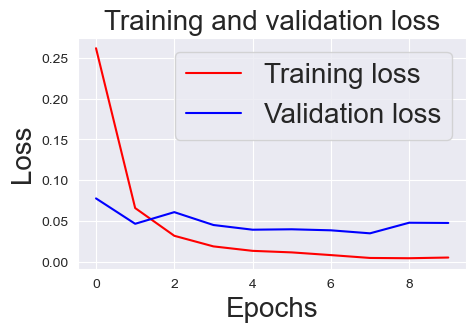

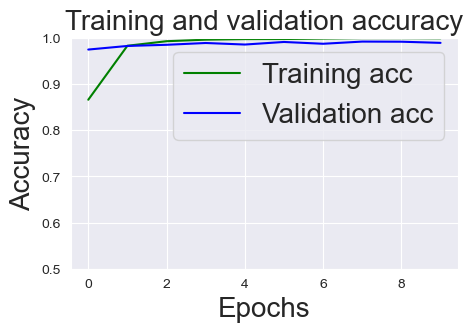

In [15]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(5,3))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(5,3))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [16]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 11s 38ms/step - loss: 0.0379 - accuracy: 0.9906


[0.03790696710348129, 0.9906458854675293]

In [17]:
pred = model.predict(X_test)
binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 10s 35ms/step


In [18]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9906458797327394
Precision on testing set: 0.9935155164427976
Recall on testing set: 0.9871145881270134


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

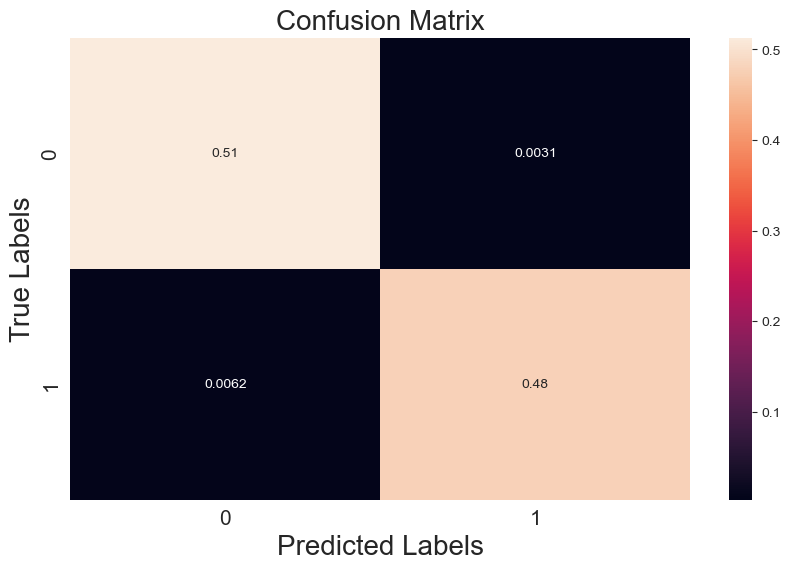

In [19]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [20]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 128)
